In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk
import string

In [2]:
df_train = pd.read_csv('train.csv') 
df_test = pd.read_csv('test.csv') 

In [3]:
df_train.sample(10)

,id,text,author
6404,id08299,I know not how many interminable aeons I sat s...,HPL
7988,id15348,His good star perpetually shone upon him; a re...,MWS
13852,id01451,I left London in a small vessel bound for a po...,MWS
166,id04172,"To add to our dilemma, we found the pumps chok...",EAP
12285,id07857,"And do you not see also, that such recherchés ...",EAP
17571,id24251,"""Ha ha ha why, Simpson, you have an astonishin...",EAP
18822,id02104,I merely laughed but he seemed quite serious i...,EAP
1550,id17475,I had drilled myself in preparation for the cr...,HPL
4179,id23741,I had most imprudently made it known among my ...,EAP
12168,id07311,I foamed I raved I swore I swung the chair upo...,EAP


In [4]:
def remove_punctuation(text):

    # For each punctuation in our list
    for punct in string.punctuation:
        # Replace the actual punctuation with a space.
        text = text.replace(punct,'')

    # Return the new text
    return text

# Now, we will apply the remove punctiation to all our text
df_train.text = df_train.text.apply(remove_punctuation)
df_test.text = df_test.text.apply(remove_punctuation)

In [5]:
APPLY_STEMMING = False

if APPLY_STEMMING:
    import nltk.stem as stm # Import stem class from nltk
    import re
    stemmer = stm.PorterStemmer()

    # Crazy one-liner code here...
    # Explanation above...
    df_train.text = df_train.text.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split(" ")]))
    df_test.text = df_test.text.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split(" ")]))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer # Import the library to vectorize the text

# Instantiate the count vectorizer with an NGram Range from 1 to 3 and english for stop words.
count_vect = CountVectorizer(ngram_range=(1,3),stop_words='english')

# Fit the text and transform it into a vector. This will return a sparse matrix.
count_vectorized = count_vect.fit_transform(df_train.text)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import the library to vectorize the text

# Instantiate the count vectorizer with an NGram Range from 1 to 3 and english for stop words.
tfidf_vect = TfidfVectorizer(ngram_range=(1,3), stop_words='english')

# Fit the text and transform it into a vector. This will return a sparse matrix.
tfidf_vectorized = tfidf_vect.fit_transform(df_train.text)

In [8]:
from sklearn.model_selection import train_test_split # Import the function that makes splitting easier.
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(count_vectorized, df_train.author, train_size=0.75)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_vectorized, df_train.author, train_size=0.75)

C:\New folder\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
from sklearn.naive_bayes import MultinomialNB


In [10]:
# Instantiate the model.
# One for Count Vectorized words
model_count_NB = MultinomialNB()
# One for TfIdf vectorized words
model_tfidf_NB = MultinomialNB()

# Train the model, passing the x values, and the target (y)
model_count_NB.fit(X_train_count, y_train_count)
model_tfidf_NB.fit(X_train_tfidf, y_train_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
predictions_count = model_count_NB.predict(X_test_count)
predictions_tfidf = model_tfidf_NB.predict(X_test_tfidf)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_count = accuracy_score(y_test_count, predictions_count)
accuracy_tfidf = accuracy_score(y_test_tfidf, predictions_tfidf)
print('Count Vectorized Words Accuracy:', accuracy_count)
print('TfIdf Vectorized Words Accuracy:', accuracy_tfidf)

Count Vectorized Words Accuracy: 0.8337078651685393
TfIdf Vectorized Words Accuracy: 0.7017364657814096


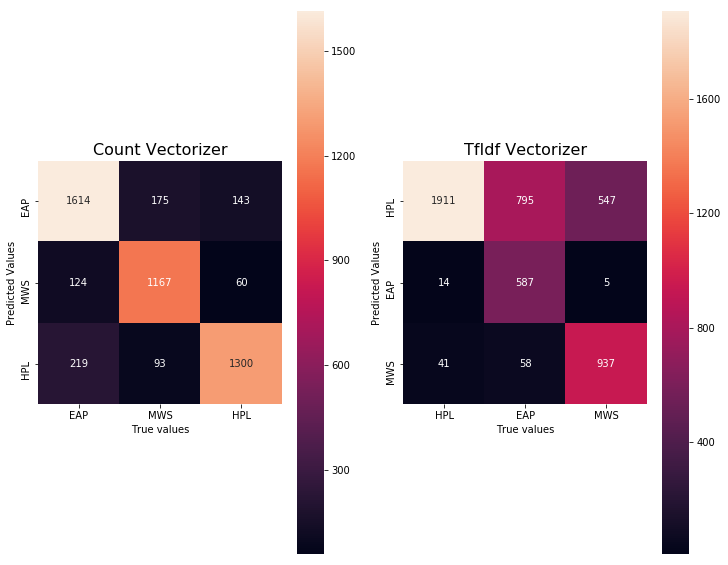

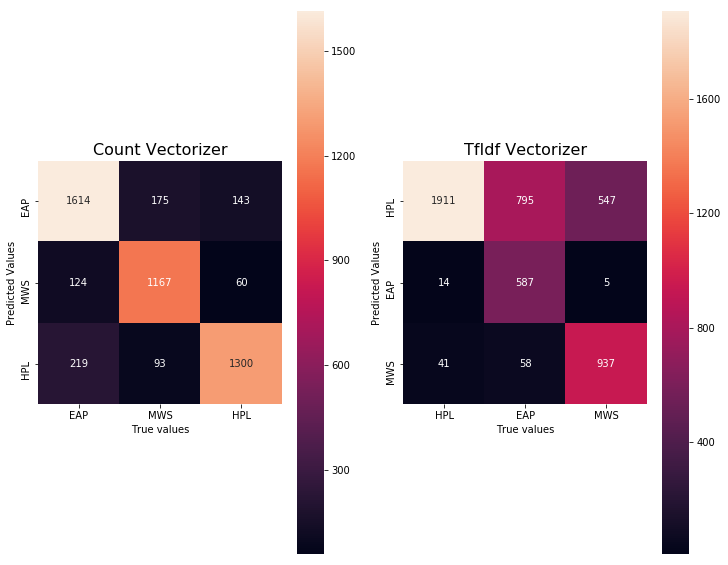

In [14]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix passing the real values and the predicted ones
# Count
conf_mat_count = confusion_matrix(y_test_count, predictions_count)
# tfIdf
conf_mat_tfidf = confusion_matrix(y_test_tfidf, predictions_tfidf)

# Set plot size
plt.figure(figsize=(12,10))
# Use 2 subplots.
plt.subplot(1,2,1)

# Finally, plot the confusion matrix using seaborn's heatmap.
sns.heatmap(conf_mat_count.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=y_test_count.unique(), yticklabels=y_test_count.unique())
plt.xlabel('True values')
plt.ylabel('Predicted Values');
plt.title('Count Vectorizer', fontsize=16)

plt.subplot(1,2,2)
# Finally, plot the confusion matrix using seaborn's heatmap.
sns.heatmap(conf_mat_tfidf.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=y_test_tfidf.unique(), yticklabels=y_test_tfidf.unique())
plt.xlabel('True values')
plt.ylabel('Predicted Values');
plt.title('TfIdf Vectorizer', fontsize=16)
plt.show()

In [15]:
model_NB = MultinomialNB()

# Train the model, passing the x values, and the target (y)
# the vectorized variable contains all the test data.
model_NB.fit(count_vectorized, df_train.author)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
X_test = count_vect.transform(df_test.text)

In [18]:
predicted_values = model_NB.predict_proba(X_test)

In [19]:
model_NB.classes_

array(['EAP', 'HPL', 'MWS'], dtype='<U3')

In [20]:
import time

# Create the submission dataframe
df_submission = pd.DataFrame({
    'id': df_test.id.values,
    'EAP': predicted_values[:,0],
    'HPL': predicted_values[:,1],
    'MWS': predicted_values[:,2]
})


# Create the date and time string. (year month day _ hours minutes seconds)
datetime = time.strftime("%Y%m%d_%H%M%S")

# generate the file name with the date, the time and the accuracy of the count vectorized test.
filename = 'submission_' + datetime + '_acc_' + str(accuracy_count) + '.csv'

# Finally, convert it to csv. Index=True tells pandas not to include the index as a column
df_submission.to_csv(filename, index=False)
print('File',filename,'created.')

File submission_20190218_200115_acc_0.8337078651685393.csv created.
